# 量子启发式算法NPU后端使用教程

[![下载Notebook](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_notebook.svg)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/master/mindquantum/zh_cn/case_library/mindspore_qaia_npu_tutorial.ipynb)&emsp;
[![下载样例代码](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_download_code.svg)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/master/mindquantum/zh_cn/case_library/mindspore_qaia_npu_tutorial.py)&emsp;
[![在Gitee上查看源文件](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_source.svg)](https://gitee.com/mindspore/docs/blob/master/docs/mindquantum/docs/source_zh_cn/case_library/qaia_npu_tutorial.ipynb)

本篇教程基于MindQuantum介绍量子启发式算法的NPU后端的参数细节和使用方法，并提供实战教程，带领开发者手把手入门。

本文将从下面六点进行展开说明：

- 昇腾平台介绍，NPU芯片的特点性能。
- 系统环境配置，检查硬件并安装软件。
- 介绍MindQuantum和量子启发式算法。
- 介绍量子启发式算法NPU后端支持的精度类型，提供矩阵运算样例代码。
- 使用量子启发式算法NPU后端求解最大割问题。
- 对比量子启发式算法在CPU和NPU后端上的性能优势。

## 昇腾平台介绍

- 达芬奇NPU核心‌：专为矩阵运算优化的3D Cube架构，昇腾芯片提供256TOPS INT8算力。
- 混合精度计算‌：支持FP32/FP16/INT8混合精度，满足深度学习、大模型训练推理和量子计算不同阶段计算需求。
- 超高能效比‌：相比传统GPU能效提升2-3倍，降低运营成本。


## 系统环境配置

### 硬件配置

- 支持昇腾NPU
- 支持算子版本：CANN-7/CANN-8


In [1]:
# 配置环境变量
!source /usr/local/Ascend/ascend-toolkit/set_env.sh

In [2]:
import os

os.environ["LD_LIBRARY_PATH"] = ":".join(
    [
        "/usr/local/Ascend/driver/lib64:",
        "/usr/local/Ascend/driver/lib64/common:",
        "/usr/local/Ascend/ascend-toolkit/latest/aarch64-linux/lib64:",
        "/usr/local/Ascend/driver/lib64/driver:",
        os.environ.get("LD_LIBRARY_PATH", ""),
    ]
)

In [3]:
# 输出系统NPU型号、数量、驱动版本
!npu-smi info

+------------------------------------------------------------------------------------------------+
| npu-smi 23.0.3                   Version: 23.0.3                                               |
+---------------------------+---------------+----------------------------------------------------+
| NPU   Name                | Health        | Power(W)    Temp(C)           Hugepages-Usage(page)|
| Chip                      | Bus-Id        | AICore(%)   Memory-Usage(MB)  HBM-Usage(MB)        |
+===========================+===============+====================================================+
| 0     910               | OK            | 93.8        40                0    / 0             |
| 0                         | 0000:C1:00.0  | 0           0    / 0          3326 / 65536         |
+===========================+===============+====================================================+
+---------------------------+---------------+----------------------------------------------------+
| NPU     Ch

### 软件安装

In [4]:
# 可选，已安装软件则不需要执行此步
# !pip install torch_npu
# !pip install mindquantum

### 验证NPU是否正常可用

In [5]:
# 检查NPU是否可用
import torch_npu

torch_npu.npu.is_available()

True

## MindQuantum介绍

**MindQuantum**是基于昇思MindSpore开源深度学习平台开发的新一代通用量子计算框架，聚焦于NISQ阶段的算法实现与落地。结合HiQ高性能量子计算模拟器和昇思MindSpore并行自动微分能力，提供极简的开发模式和极致的性能体验。

MindQuantum已经[集成量子启发式算法模块](https://www.mindspore.cn/mindquantum/docs/zh-CN/r0.11/algorithm/mindquantum.algorithm.qaia.html)，并提供**CPU、GPU、NUP/昇腾**版本，适配多种硬件设备，并提供极致性能。

量子启发式算法是一类基于**量子力学原理**的计算方法衍生或启发的经典力学方法，旨在利用量子力学的独特性质（叠加态、量子纠缠和量子并行性）来改进传统算法的性能。

常见的**量子启发式算法**包括：

- ASB（Adiabatic Simulated bifurcation/绝热模拟分叉算法）
- BSB（Ballistic Simulated bifurcation/弹道模拟分叉算法）
- DSB（Discrete Simulated bifurcation/离散模拟分叉算法）
- SimCIM（Simulated Coherent Ising Machine/模拟相干伊辛机算法）
- LQA（Local Quantum Annealing/局部量子退火算法）



## 量子启发式算法NPU后端

量子启发式算法[支持后端](https://www.mindspore.cn/mindquantum/docs/zh-CN/r0.11/algorithm/qaia/mindquantum.algorithm.qaia.QAIA.html#mindquantum.algorithm.qaia.QAIA)：

- backend (str) - 计算后端和精度：'cpu-float32'、'gpu-float32'、'gpu-float16'、'gpu-int8' 或 'npu-float32'，默认值： 'cpu-float32'。
- NPU后端现支持的数据精度：float32

### 矩阵运算样例

In [6]:
from scipy.sparse import coo_matrix
from mindquantum.algorithm.qaia import DSB

# 矩阵[[0,-1],[-1,0]]
J = coo_matrix(([-1, -1], ([0, 1], [1, 0])), shape=(2, 2))
solver = DSB(J, batch_size=10, backend="npu-float32")
solver.update()
cut = solver.calc_cut()
energy = solver.calc_energy()

print(f"Cut: {cut}\nEnergy: {energy}")

Cut: tensor([0., 1., 1., 1., 1., 1., 0., 1., 1., 0.], device='npu:0')
Energy: tensor([ 1., -1., -1., -1., -1., -1.,  1., -1., -1.,  1.], device='npu:0')


## 实战案例-使用量子启发式算法求解最大割问题

In [7]:
# 导入需要的Python模块
from mindquantum.algorithm.qaia import DSB
import numpy as np
import pandas as pd
from scipy.sparse import coo_matrix
import time

In [8]:
# 数据准备
# 下载数据，无向图数据集来源于GSet
import requests

graph_file = "https://web.stanford.edu/~yyye/yyye/Gset/G22"

# 使用requests库中的get方法发送HTTP请求，将url的响应结果存入变量，再以二进制写入模式打开文件写入本地
response = requests.get(graph_file)
open("G22", "wb").write(response.content)


# 如果上述-下载图集的代码执行，报错TimeoutError，说明是网络问题
# 可以手动点击网址 https://web.stanford.edu/~yyye/yyye/Gset/G22，下载数据，保存在本地，与该教程同级目录

217828

In [9]:
# 数据处理
def read_gset(filename, negate=True):
    # 读取图表
    graph = pd.read_csv(filename, sep=" ")
    # 节点的数量
    n_v = int(graph.columns[0])
    # 边的数量
    n_e = int(graph.columns[1])

    # 如果节点和边不匹配，会抛出错误
    assert n_e == graph.shape[0], "The number of edges is not matched"

    # 将读取的数据转换为一个COO矩阵（Coordinate List Format），并返回一个稀疏矩阵
    G = coo_matrix(
        (
            np.concatenate([graph.iloc[:, -1], graph.iloc[:, -1]]),
            (
                np.concatenate([graph.iloc[:, 0] - 1, graph.iloc[:, 1] - 1]),
                np.concatenate([graph.iloc[:, 1] - 1, graph.iloc[:, 0] - 1]),
            ),
        ),
        shape=(n_v, n_v),
    )
    if negate:
        G = -G

    return G


G = read_gset("./G22")

In [10]:
start_time = time.time()
solver = DSB(G, batch_size=100, n_iter=1000, backend="npu-float32")
solver.update()
cut = solver.calc_cut()
end_time = time.time()


print(f"G22 MAXCut is : {max(cut)}\nuse time:{end_time-start_time}")

G22 MAXCut is : 13353.0
use time:0.5273990631103516


## 性能对比

对比BSB算法在CPU和NPU后端上求解最大割问题的性能优势

In [11]:
import time

start_time = time.time()
solver = DSB(G, batch_size=100, n_iter=1000, backend="cpu-float32")
solver.update()
cut = solver.calc_cut()
cpu_fp32_time = time.time() - start_time

start_time = time.time()
solver = DSB(G, batch_size=100, n_iter=1000, backend="npu-float32")
solver.update()
cut = solver.calc_cut()
npu_fp32_time = time.time() - start_time

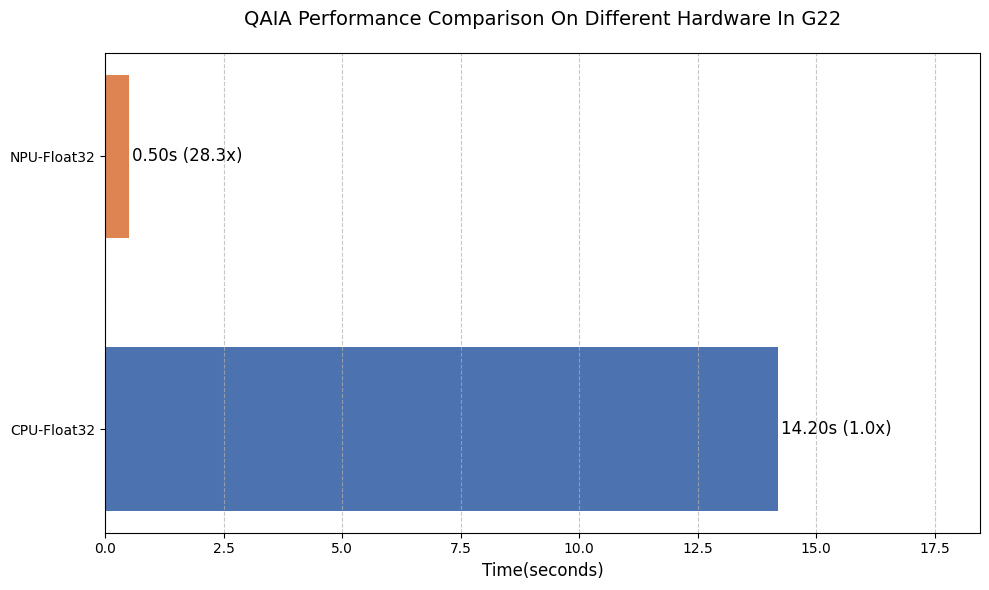

In [12]:
import matplotlib.pyplot as plt

# 计算加速比
cpu_speedup = cpu_fp32_time / cpu_fp32_time
npu_speedup = cpu_fp32_time / npu_fp32_time


devices = ["CPU-Float32", "NPU-Float32"]
times = [cpu_fp32_time, npu_fp32_time]
speedups = [cpu_speedup, npu_speedup]
colors = ["#4C72B0", "#DD8452"]


plt.figure(figsize=(10, 6), dpi=100)

# 绘制横向条形图, 表示不同后端的计算时间
bars = plt.barh(devices, times, color=colors, height=0.6)

# 添加数据标签和加速比
for i, (time, speedup) in enumerate(zip(times, speedups)):
    plt.text(
        time + 0.05,
        i,
        f"{time:.2f}s ({speedup:.1f}x)",
        va="center",
        fontsize=12,
    )

plt.title(
    "QAIA Performance Comparison On Different Hardware In G22", fontsize=14, pad=20
)
plt.xlabel("Time(seconds)", fontsize=12)
plt.xlim(0, max(times) * 1.3)
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.tight_layout()

plt.show()

In [13]:
from mindquantum.utils.show_info import InfoTable

InfoTable("mindquantum", "scipy", "numpy")